# Spatio-temporal Transcriptomics

Toy dataset from López-Lopera et al. (2019)

- Data download: https://github.com/anfelopera/PhysicallyGPDrosophila

In [1]:
import numpy as np
import torch

from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Interval
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path

from torch.optim import Adam
from gpytorch.optim import NGD
from experiments.partial import build_partial, plot_partial, pretrain_partial

from lafomo.models import MultiOutputGP, PartialLFM
from lafomo.models.pdes import ReactionDiffusion
from lafomo.utilities.torch import discretise, softplus
from lafomo.utilities.fenics import interval_mesh
from lafomo.datasets import DrosophilaSpatialTranscriptomics, HomogeneousReactionDiffusion
from lafomo.trainers import PartialPreEstimator
from lafomo.plot import plot_spatiotemporal_data
from lafomo.utilities.torch import spline_interpolate_gradient, softplus

from lafomo.configuration import VariationalConfiguration

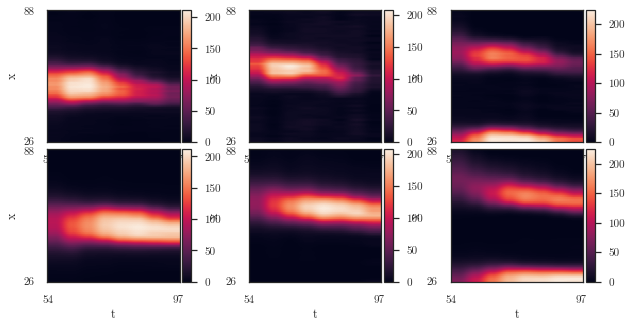

In [3]:
drosophila = True
kni_params = dict(sensitivity=0.183,
                  decay=0.0770,
                  diffusion=0.0125)
gt_params = dict(sensitivity=0.1107,
                  decay=0.1110,
                  diffusion=0.0159)
kr_params = dict(sensitivity=0.0970,
                 decay=0.0764,
                 diffusion=0.0015)
params = dict(kr=kr_params, kni=kni_params, gt=gt_params)
if drosophila:
    gene = 'kr'
    dataset = DrosophilaSpatialTranscriptomics(
        gene=gene, data_dir='../../../data', scale=True)
    params = dict(lengthscale=10,
                  **params[gene],
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=True,
                  zero_mean=True,
                  clamp=True)
    disc = dataset.disc
else:
    data = 'toy-spatial'
    dataset = HomogeneousReactionDiffusion(data_dir='../../../data')
    params = dict(lengthscale=0.2,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  warm_epochs=-1,
                  dp=0.025,
                  natural=False,
                  clamp=False)
    disc = 1
model_name = '0savedmodel'
# model_name = 'epoch165'
# model_name = 'model_with_3'
lfm, trainer, plotter = build_partial(
    dataset,
    params)#,
    # reload=f'../../../experiments/{data}/partial/{model_name}')

We can either create a simple unit interval mesh

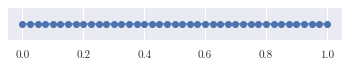

In [3]:
from dolfin import *

mesh = UnitIntervalMesh(40)
plot(mesh)

Alternatively, if our spatial data is not uniformly spaced, we can define a custom mesh as follows.

Matching: True


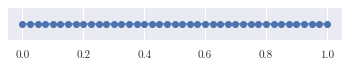

In [4]:
# We calculate a mesh that contains all possible spatial locations in the dataset

spatial = np.unique(tx[1, :])
mesh = interval_mesh(spatial)
plot(mesh)
# The mesh coordinates should match up to the data:
print('Matching:', all(spatial == mesh.coordinates().reshape(-1)))

Set up GP model

torch.Size([1, 504, 2])


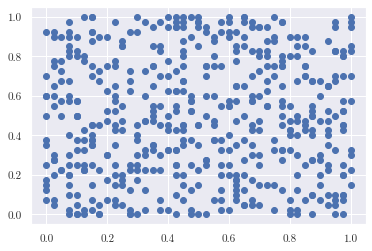

In [5]:
inducing_points = torch.stack([
    tx[0, torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]],
    tx[1, torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]]
], dim=1).unsqueeze(0)

gp_kwargs = dict(use_ard=True,
                 use_scale=False,
                 # lengthscale_constraint=Interval(0.1, 0.3),
                 learn_inducing_locations=False,
                 initial_lengthscale=lengthscale)
gp_model = MultiOutputGP(inducing_points, 1, **gp_kwargs)
gp_model.double();

print(inducing_points.shape)
plt.scatter(inducing_points[0,:,0], inducing_points[0, :, 1])

Set up PDE

In [6]:
t_range = (ts[0], ts[-1])
print(t_range)
time_steps = dataset.num_discretised
print(time_steps)

fenics_model = ReactionDiffusion(t_range, time_steps, mesh)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=25
)

sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
fenics_params = [sensitivity, decay, diffusion]

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config)

(0.0, 1.0)
40


In [9]:
train_mask = torch.zeros_like(tx[0,:])
train_mask[torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]] = 1

num_training = tx.shape[1]
variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.07)
optimizers = [variational_optimizer, parameter_optimizer]

trainer = PDETrainer(lfm,
                     optimizers,
                     dataset,
                     track_parameters=list(lfm.fenics_named_parameters.keys()),
                     train_mask=train_mask.bool(),
                     warm_variational=1)

t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025
x dp is set to 0.025
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025


Now let's see some samples from the GP and corresponding LFM output


KeyboardInterrupt: 

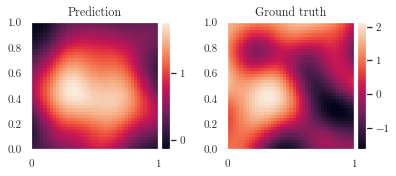

<Figure size 432x288 with 0 Axes>

In [10]:
num_t = trainer.tx[0, :].unique().shape[0]
num_x = trainer.tx[1, :].unique().shape[0]

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(trainer.tx.transpose(0, 1))

sample = out.sample(torch.Size([lfm.config.num_samples])).permute(0, 2, 1)
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0)


plot_spatiotemporal_data(
    [sample.mean(0)[0].detach().view(num_t, num_x).transpose(0, 1),
    real.squeeze().view(num_t, num_x).transpose(0, 1)],
    extent,
    titles=['Prediction', 'Ground truth']
)

sample = sample.view(lfm.config.num_samples, 1, num_t, num_x)
real = real.repeat(lfm.config.num_samples, 1, 1)
real = real.view(lfm.config.num_samples, 1, num_t, num_x)

out = lfm.solve_pde(sample)
real_out = lfm.solve_pde(real)

plot_spatiotemporal_data(
    [out.mean(0).detach().transpose(0, 1),
    real_out[0].detach().transpose(0, 1)],
    extent,
    titles=['Prediction', 'Ground truth']
)

In [ ]:
sensitivity = (torch.tensor(params['sensitivity']))
decay = (torch.tensor(params['decay']))
diffusion = (torch.tensor(params['diffusion']))
orig_data = dataset.orig_data.squeeze().t()
num_t_orig = orig_data[:, 0].unique().shape[0]
num_x_orig = orig_data[:, 1].unique().shape[0]

tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t_orig, num_x_orig)

pde_func, pde_target = lfm.fenics_model.interpolated_gradient(tx, y_matrix, disc=disc, plot=True)

u = orig_data[trainer.t_sorted, 2].view(num_t_orig, num_x_orig)
u = u.view(1, -1)
print(u.shape)
dy_t_ = pde_func(
    trainer.y_target,
    u.repeat(25, 1),
    sensitivity.unsqueeze(0).repeat(25, 1),
    decay.unsqueeze(0).repeat(25, 1),
    diffusion.unsqueeze(0).repeat(25, 1))[0]

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
plot_spatiotemporal_data([dy_t_.view(num_t, num_x).t()],
                         extent=extent, figsize=(3,3))

In [ ]:
train_ratio = 0.3
num_training = int(train_ratio * tx.shape[1])
print(num_training)
if params['natural']:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.09)]


pre_estimator = PartialPreEstimator(
    lfm, optimizers, dataset, pde_func,
    input_pair=(trainer.tx, trainer.y_target), target=pde_target,
    train_mask=trainer.train_mask
)

In [ ]:
import time
t0 = time.time()
lfm.pretrain(True)
lfm.config.num_samples = 50
times = pre_estimator.train(100, report_interval=5)
lfm.config.num_samples = 5

In [ ]:
from lafomo.utilities.torch import q2, cia
lfm.eval()
f = lfm(tx)
print(f.mean.shape)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]

print(f_mean.shape, y_target.shape, f_var.shape)
print('prot Q2', q2(y_target.squeeze(), f_mean.squeeze()))
print('prot CA', cia(y_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))
gp = lfm.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach().view(num_t, num_x)[::disc].reshape(-1)
f_var = gp.variance.detach().view(num_t, num_x)[::disc].reshape(-1)

print('mrna Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('mrna CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))


print(np.stack(times).shape)
plt.plot(np.stack(times)[:, 1])

In [ ]:
#print(hihi)

trainer.train(2)

In [24]:
print(sample.shape)

plt.imshow(sample.mean(0)[0].transpose(0, 1))
plt.colorbar()
plt.figure()
plt.imshow(out.mean(0).detach())
# lfm.save(filepath)

torch.Size([25, 1, 512])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [25]:
lfm = PartialLFM.load(filepath,
                      gp_cls=MultiOutputGP,
                      gp_args=[inducing_points, 1],
                      gp_kwargs=gp_kwargs,
                      lfm_args=[1, fenics_model, fenics_params, config])
# lfm = PartialLFM(gp_model, fenics_model, fenics_params, config)

gp_model = lfm.gp_model
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset, track_parameters=list(lfm.fenics_named_parameters.keys()))

t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


In [26]:
from lafomo.utilities.torch import smse, cia, q2

tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
# f_mean = lfm(tx).mean.detach()
# f_var = lfm(tx).variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1] - ts[0]
x_diff = xs[-1] - xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]
print(y_target.shape, f_mean.squeeze().shape)
f_mean_test = f_mean.squeeze()
f_var_test = f_var.squeeze()

print(q2(y_target, f_mean.squeeze()))
print(cia(y_target, f_mean_test, f_var_test).item())
print(smse(y_target, f_mean_test).mean().item())

NameError: name 'f_mean' is not defined

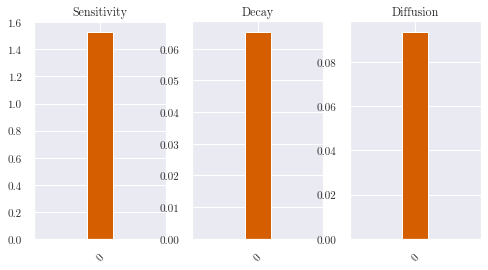

In [32]:
plotter = Plotter(lfm, np.arange(1))

labels = ['Sensitivity', 'Decay', 'Diffusion']
kinetics = list()
for key in lfm.fenics_named_parameters.keys():
    kinetics.append(softplus(trainer.parameter_trace[key][-1]).squeeze().numpy())

plotter.plot_double_bar(kinetics, labels)

# plotter.plot_latents()